In [ ]:
# Final Revision of Capstone Fold Sampling Strategy

In [ ]:
# Data Sample Assembly File Notes:
# File Sequence # 5

# The purpose of this notebook is to produce a finalized data set...
# ... across splits appropriate for a time series...
# ... for model input

# input =
# A. KPI calculated dataset

# output =
# A. Final train/val/test df with labeled data


In [ ]:
# mount google drive
from google.colab import drive
# this resets all file variables
drive.flush_and_unmount()
# mount/remount
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
# imports

# data manipulation and calculations:
import pandas as pd
import numpy as np
# train test split for time series
from sklearn.model_selection import TimeSeriesSplit
# scaling
from sklearn.preprocessing import MinMaxScaler
# file hadling
import os
# plotting fold structure:
import matplotlib.pyplot as plt
# one hot encoding
#from sklearn.preprocessing import OneHotEncoder
# (the team ultimately decided to abandon OHE for two reasons, discussed in paper)
# (1. Constraints of shared system)
# (2. Nature of modeling)

In [ ]:
# Define primary notebook objects:

# location of shared drive
shared_drive_path = r"/content/drive/MyDrive/Capstone_Docs_Shared"

# project demo data:
demo_file_name = "kpi_calc_1992_0601_thru_1998_1130.csv"

# construct full filepath
filepath = os.path.join(shared_drive_path, demo_file_name)
print(filepath)

# Data labeling thresholds
# high threshold
thresh_high = 0.05
# mid threshold
thresh_mid = 0.01


/content/drive/MyDrive/Capstone_Docs_Shared/kpi_calc_1992_0601_thru_1998_1130.csv


In [ ]:
# Import downloaded data with KPI calculations

# read data to NB:
stock_data = pd.read_csv(filepath)
print("Import Doc Values Check:")
print("")

print("Total NaN Values: ")
print(stock_data.isna().sum().sum())

# check for infinite values
print("Total Inf Values: ")
print(stock_data.isin([np.inf, -np.inf]).sum().sum())


Import Doc Values Check:

Total NaN Values: 
0
Total Inf Values: 
0


In [ ]:
# More summary information from dL file:

# check num unique tickers for analysis:
print('Number of Unique Ticker Symbols Imported:')
u_tickers = stock_data['Ticker'].unique()
print(len(u_tickers))

# Date range check
print('Date Range Imported: ')
beg_date = min(stock_data['Date'])
print(beg_date)
end_date = max(stock_data['Date'])
print(end_date)

# Price information
print('Price Range Imported: ')
min_close = min(stock_data['Close'])
print(min_close)
max_close = max(stock_data['Close'])
print(max_close)


Number of Unique Ticker Symbols Imported:
885
Date Range Imported: 
1992-06-01
1998-11-30
Price Range Imported: 
-612.974365234375
1535.3941650390625


In [ ]:
# Function 1: Sampling Function
# (use this function if you want to further filter date range)
# (helpful if notebook size starts overloading system, you can manage locally)

def sampling(source_df, beg_date, end_date):
  # filter source by date
  filtered_df = source_df[(source_df['Date'] >= beg_date) & (source_df['Date'] <= end_date)]
  # sort df by ticker and date
  filtered_df = filtered_df.sort_values(by=['Ticker', 'Date'])
  return filtered_df

# Check

In [ ]:
# Function 2: Calculating Returns Function
# (these calculated returns form basis of signals, basis of all predictions)

def calc_returns(source_df):
  # Steps:
  # A. Calculations Actual
  # B. Calculations Offset

  # A. Calculate Actual Returns for each ticker
  # calculate daily returns
  source_df['D_Return'] = source_df.groupby('Ticker')['Close'].pct_change()
  # calculate weekly returns:
  source_df['W_Return'] = source_df.groupby('Ticker')['Close'].pct_change(periods=7)
  # calculate monthly returns:
  source_df['M_Return'] = source_df.groupby('Ticker')['Close'].pct_change(periods=30)

  # B. Roll Actual Returns back 1 day to prevent data leakage
  # (this is the return which this stock generated yesterday)
  # (as opposed to: this is the return which will be generated today)
  source_df['D_Return_Offset'] = source_df.groupby('Ticker')['D_Return'].shift(1)
  source_df['W_Return_Offset'] = source_df.groupby('Ticker')['W_Return'].shift(1)
  source_df['M_Return_Offset'] = source_df.groupby('Ticker')['M_Return'].shift(1)

  # (drop regular return columns in a later notebook - before model training)
  # (this prevents data leakage)

  # also to prevent data leakage, we should do this with Open, Low, High, Close, and Volume:
  source_df['Open_Offset'] = source_df.groupby('Ticker')['Open'].shift(1)
  source_df['Low_Offset'] = source_df.groupby('Ticker')['Low'].shift(1)
  source_df['High_Offset'] = source_df.groupby('Ticker')['High'].shift(1)
  source_df['Close_Offset'] = source_df.groupby('Ticker')['Close'].shift(1)
  source_df['Volume_Offset'] = source_df.groupby('Ticker')['Volume'].shift(1)

  # need to fill nans which are generated by the rolling calculations:
  # (e.x. if calculating for the last month, but only 5 days available...
  # ...return nan value)
  source_df = source_df.fillna(0)

  return source_df

# Check

In [ ]:
# Function 3: Labeling Function
# (these are the signals generated by the return calcs)
# (these signals are what the project is trying to predict)
# (takes some threshold levels as input for labeling)

def assign_labels(df, thresh_mid, thresh_high):
  # assign labels based on several assigned thresholds

    # Label Method I: Binary Label

    # label based on daily return
    df['D_2_Label'] = np.where(df['D_Return'] > 0, 1, 0)
    # label based on weekly return
    df['W_2_Label'] = np.where(df['W_Return'] > 0, 1, 0)
    # label based on monthly return
    df['M_2_Label'] = np.where(df['M_Return'] > 0, 1, 0)

    # Label Method II: Threshold Lableing

    # Buy Scenario:
    # if future (expected) return > X%, then label = 1

    # Sell Scenario:
    # if future (expected) return < -X%, then label = -1

    # Hold Scenario:
    # if future (expected) return between -X% and X%, then label = 0

    # Sub-Function for Positive Threshold Labeling:
    def label_pos_threshold(df, col, h_threshold):

      # threshold conditions list:
      thresholds = [
          df[col] > h_threshold,
          (df[col] > 0) & (df[col] <= h_threshold),
          df[col] <= 0,
      ]

      # label values to map to categories
      map_vals = [1,0,-1]

      # use numpy select to map groupings to labels
      labels = np.select(thresholds, map_vals)

      return labels

    # Label Method III: Extended Threshold Labeling

    # Substantial Increase Scenario:
    # if expected return > X%, then label 2

    # Moderate Increase Scenario:
    # if expected return > 0, < X%, then label 1

    # Level Price Scenario:
    # if expected return ~ 0, then label 0

    # Moderate Decrease Scenario:
    # if expected return < 0, > -X%, then label -1

    # Substantial Decrease Scenario
    # if expected return < -X%, then label -2

    # Sub-Function for Symmetrical Threshold Labeling:
    def label_extended_threshold(df, col, l_threshold, h_threshold):
      # need 2 lists ....
      # ... list of thresholds ...
      # ... list of map values ...

      # threshold conditions list:
      thresholds = [
          df[col] > h_threshold,
          (df[col] > l_threshold) & (df[col] <= h_threshold),
          (df[col] <= l_threshold) & (df[col] >= -l_threshold),
          (df[col] < -l_threshold) & (df[col] >= -h_threshold),
          df[col] < -h_threshold
      ]

      # label values to map to categories
      map_vals = [2,1,0,-1,-2]

      # use numpy select to map groupings to labels
      labels = np.select(thresholds, map_vals)

      return labels

    # assign threshold labels based on Positive Threshold
    df['D_3_Label'] = label_pos_threshold(df, 'D_Return', thresh_high)
    df['W_3_Label'] = label_pos_threshold(df, 'W_Return', thresh_high)
    df['M_3_Label'] = label_pos_threshold(df, 'M_Return', thresh_high)
    # assign threshold labels based on Symmetrical Threshold

    df['D_5_Label'] = label_extended_threshold(df, 'D_Return', thresh_mid, thresh_high)
    df['W_5_Label'] = label_extended_threshold(df, 'W_Return', thresh_mid, thresh_high)
    df['M_5_Label'] = label_extended_threshold(df, 'M_Return', thresh_mid, thresh_high)

    return df

# Check

In [ ]:
# Function 4: Fold and Split Generation Function
# (separates data into T/V/T folds with T/T split per fold)
# (this is implemented using sklearn TimeSeriesSplit, ensuring no data leakage)

def train_val_test_split(df):

  # define data to split
  split_df = df.copy()

  # sort by date:
  split_df = split_df.sort_values(by=['Date'])

  # time series split object
  tscv = TimeSeriesSplit(n_splits=3)

  # define list to store train/test split tuple per fold
  tt_folds_list = []

  # need to get output dfs to be date-exclusive....
  # ... i.e. a given day can only appear in one split per fold
  # Solution:
  # create unique date list, draw split from date list
  u_dates = split_df['Date'].sort_values().unique()

  # tss object returns a list of indexes, use those to select each day's data
  for fold, (train_idxs, test_idxs) in enumerate(tscv.split(u_dates)):

    # take split indexes
    train_dates = u_dates[train_idxs]
    test_dates = u_dates[test_idxs]

    # define mask / map to retreive data
    train_mask = split_df['Date'].isin(train_dates)
    test_mask = split_df['Date'].isin(test_dates)

    # make actual data retreival
    train_df = split_df[train_mask]
    test_df = split_df[test_mask]

    # append t/t/ split to output list
    tt_folds_list.append((train_df, test_df))

  return tt_folds_list

# Check

In [ ]:
# Function 5: Scaling Function
# Scale at this point for following reasons:
# 1. All Features have been generated
# 2. All Folding and Splitting has occurred

def scale_folds(folds, label_cols, cat_col):
  # initiate list to store scaled column dfs
  scaled_folds = []

  # initiate loop to iterate over input fold dfs
  for i, (train_df, test_df) in enumerate(folds):

    # ID Returns Columns - Do not want to scale these
    ret_cols = train_df.filter(like='Return').columns.tolist()

    # separate x and y values -- supposed to be best practice
    X_train = train_df.drop(columns=label_cols)
    X_train = X_train.drop(columns=ret_cols)
    y_train = train_df[label_cols]
    X_test = test_df.drop(columns=label_cols)
    X_test = X_test.drop(columns=ret_cols)
    y_test = test_df[label_cols]

    # find numeric columns in input dataframe:
    numeric_cols = X_train.select_dtypes(include='number').columns
    # (make sure numeric_cols doesnt contain ticker or date, OR labels)

    # define scaler object
    scaler = MinMaxScaler()

    # need numeric columns as a list here?
    numeric_col_list = numeric_cols.tolist()

    # fit scaler on train set
    scaler.fit(X_train[numeric_col_list])

    # perform actual scaling in both train and test
    X_train_num_scaled = scaler.transform(X_train[numeric_col_list])
    X_test_num_scaled = scaler.transform(X_test[numeric_col_list])

    # convert scaled arrays to dfs for incorporation
    X_train_scaled = pd.DataFrame(X_train_num_scaled, columns=numeric_col_list)
    X_test_scaled = pd.DataFrame(X_test_num_scaled, columns=numeric_col_list)

    # take other, unscaled, columns and re-add them to scaled columns
    train_unscaled_cols = train_df.drop(columns=numeric_col_list).reset_index(drop=True)
    test_unscaled_cols = test_df.drop(columns=numeric_col_list).reset_index(drop=True)

    # reset indexes??
    train_final_scale = pd.concat([train_unscaled_cols,X_train_scaled], axis=1)
    test_final_scale = pd.concat([test_unscaled_cols,X_test_scaled], axis=1)

    # send folds to output list as tuple:
    scaled_folds.append((train_final_scale, test_final_scale))

  return scaled_folds
  # (list of tuples)

# Check

In [ ]:
# Function 6: Export Function
# (need to export folds kind of carefully)

def export_labeled_folds(folds, output_folder):
  # get idx, train df and test df from folds list
  for i, (df_train_final, df_test_final) in enumerate(folds):
    # assemble output filepaths
    train_output_path = os.path.join(output_folder, f'train_fold_{i+1}.csv')
    test_output_path = os.path.join(output_folder, f'test_fold_{i+1}.csv')
    # Make data Export
    df_train_final.to_csv(train_output_path, index=False)
    df_test_final.to_csv(test_output_path, index=False)
    print(f"Fold {i+1} Exported Successfully")

# Check

In [ ]:
# Generate output dataframe based on progression of functions:

# DEFINE TARGET FIELD FOR LABELS
target_fields = ['D_2_Label', 'W_2_Label', 'M_2_Label',
                 'D_3_Label', 'W_3_Label', 'M_3_Label',
                 'D_5_Label', 'W_5_Label', 'M_5_Label',
                 'Close']

# DEFINE CATEGORY COLUMNS FOR ENCODING
categ_cols = 'Ticker'

# 1. Sub-sample date range if you need to :
#stock_data = sampling(stock_data, '1992-06-01', '1998-11-30')

# 2. Calculate actual return and offset return
ret_df = calc_returns(stock_data)

# 3. Assign labels based on actual returns
labeled_df = assign_labels(ret_df, thresh_mid, thresh_high)

# 4. Execute Train/Validation/Test Fold split
fold_df_list = train_val_test_split(labeled_df)

# 5. Perform scaling across folds
scaled_folds = scale_folds(fold_df_list, target_fields, categ_cols)

# 6. Perform one hot encoding across folds
# (The team decided against OHE for various reasons:
# A. Constraints of shared system
# B. Nature of modeling loop - only one 'category' at a time
# C. Only had one categorical column)
# ** Please contact the team if you would like to see a copy...
# ... of the OHE function. We are keeping one handy for future iterations

# 7. Export folds to csv files in project folder
# Ideal:
#export_labeled_data(encoded_folds, shared_drive_path)
# scaled only:
export_labeled_folds(scaled_folds, shared_drive_path)


Fold 1 Exported Successfully
Fold 2 Exported Successfully
Fold 3 Exported Successfully


In [ ]:
# Visualization Generation:
# Seen vs Unseen Data across Folds

def plot_folds_for_ticker(scaled_folds, ticker):

  #count number of fold to determine number of subplots
  num_folds = len(scaled_folds)

  #creat subplots, one per fold
  #need shared x axis
  fig, axes = plt.subplots(nrows=num_folds, ncols=1, figsize=(16, 3 * num_folds), sharex=True, sharey=True)

  #loop through folds
  for i, (train_df, test_df) in enumerate(scaled_folds):

    # grab plot for each axis
    axis = axes[i]

    #filter data sets for one ticker
    train_ticker = train_df[train_df['Ticker'] == ticker].copy()
    test_ticker = test_df[test_df['Ticker'] == ticker].copy()

    #must convert to datetime
    train_ticker['Date'] = pd.to_datetime(train_ticker['Date'])
    test_ticker['Date'] = pd.to_datetime(test_ticker['Date'])

    # plot train and test data
    axis.plot(train_ticker['Date'], train_ticker['Close'], 'o', markersize=2, color='blue', label='Train')
    axis.plot(test_ticker['Date'], test_ticker['Close'], 'o', markersize=2, color='red', label='Test')

    #change font size for tick labels for paper
    axis.tick_params(axis='x', labelsize=16)
    axis.tick_params(axis='y', labelsize=16)

    # hide x axis ticks on fold 1 and 2
    if i < num_folds - 1:
      #hides all of x axis for fold 1 and 2
      axis.get_xaxis().set_visible(False)

    # add y axis label to each subplot
    axis.set_ylabel('Closing Price', fontsize= 20)

    #plot fold label on y axis
    axis.text(-0.13, 0.5, f"Fold {i+1}", transform=axis.transAxes,
          fontsize=20, weight='bold')

  # add title
  fig.suptitle("Time Series Split Cross Validation Folds for Single Ticker", fontsize=22, weight='bold')

  #add x label to fold 3
  fig.supxlabel("Date", fontsize=20)

  # add legend
  fig.legend(['Unseen', 'Seen'], fontsize=20,  bbox_to_anchor=(0.95, 0.9), markerscale=3)

  #limit space between indivisual graphs
  plt.tight_layout()
  plt.show()


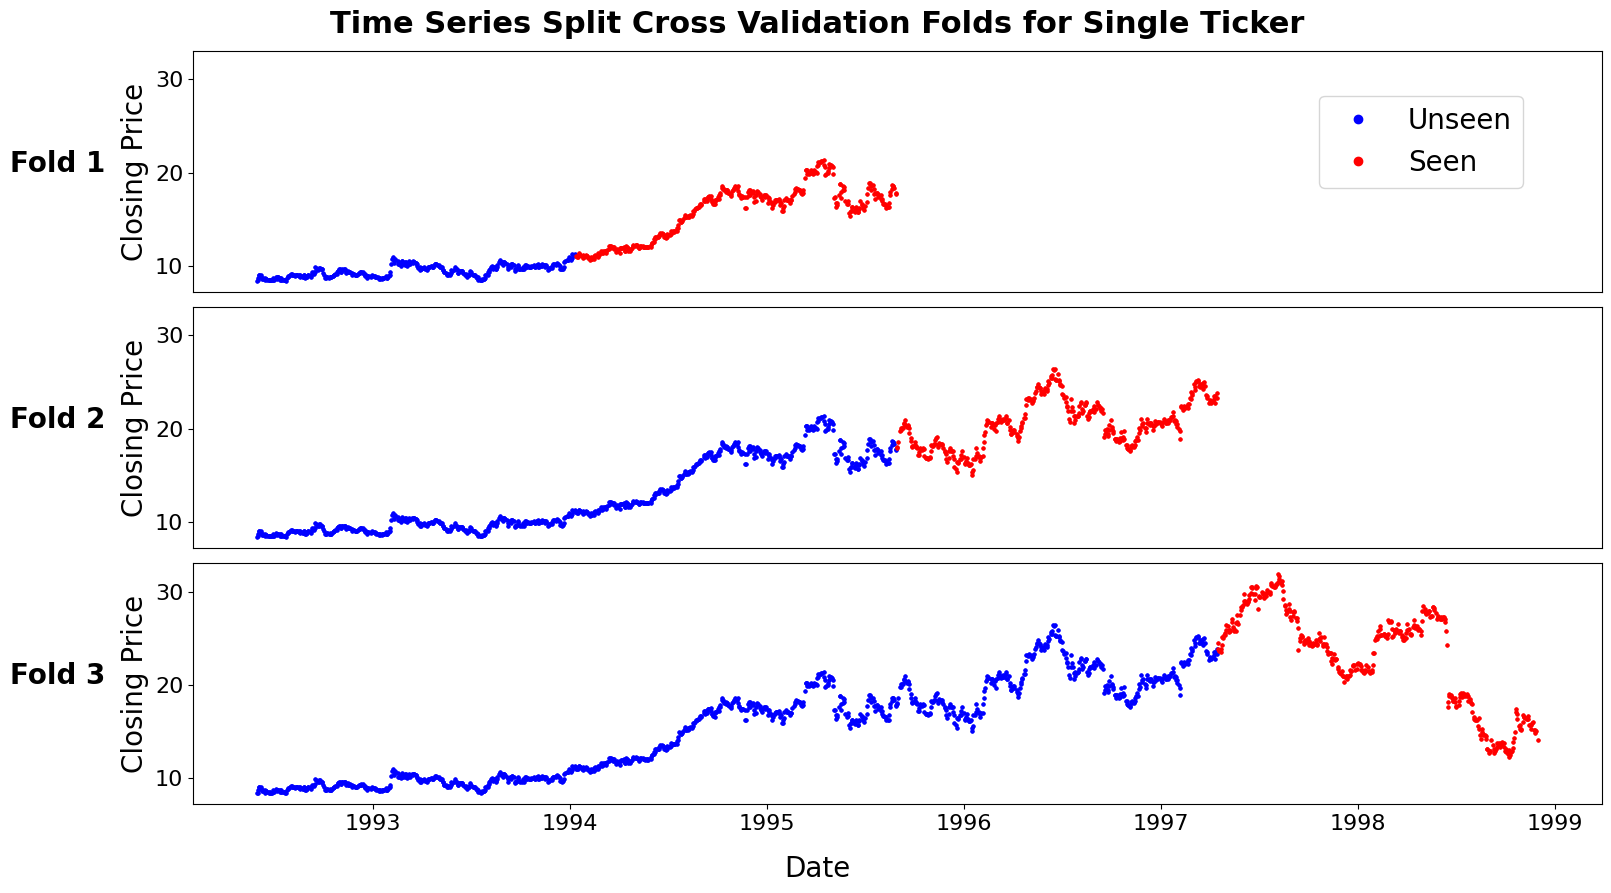

In [ ]:
# MAN ticker selected for plot display
plot_folds_for_ticker(scaled_folds, ticker="MAN")